# EXPLORATORY ANALYSIS - PCoA

This Jupyter Notebook contains main functions to visualise longitudinal gut microbiome data
1. Calculate Aitchinson distance between all timepoints of 4 subjects at once
2. Run PCoA on Aitchinson distance matrix
3. Visualise 2 first components
4. Calculate separate Aitchinson distance for each subejcts time points
5. Run PCoA on Aitchinson distance matrix
6. Visualise 2 first components

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm 
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

from scipy.spatial import distance
from skbio.stats import composition
from skbio.stats.ordination import pcoa   
from sklearn.decomposition import PCA

sns.set_style('white')

In [2]:
wd =  './data/'

In [3]:
# read files
male_df = pd.read_csv(wd + 'ready_files/male_rarefied_18000_interpolated_pchip.tsv', index_col = [0], sep = '\t')
male_df = male_df.T

female_df = pd.read_csv(wd + 'ready_files/female_rarefied_18000_interpolated_pchip.tsv', index_col = [0], sep = '\t')
female_df = female_df.T

donorA_df = pd.read_csv(wd + 'ready_files/donorA_rarefied_18000_interpolated_pchip.tsv', index_col = [0], sep = '\t')
donorA_df = donorA_df.T

donorB_df = pd.read_csv(wd + 'ready_files/donorB_rarefied_18000_interpolated_pchip.tsv', index_col = [0], sep = '\t')
donorB_df = donorB_df.T

# I. PCA ON ALL 4 SUBJECTS

In [4]:
male_df['subject'] = 'male'
female_df['subject'] = 'female'
donorA_df['subject'] = 'donorA'
donorB_df['subject'] = 'donorB'

concatenated_df = pd.concat([male_df, female_df, donorA_df, donorB_df], axis=0).fillna(0)

#change counts into clr with pseudocount 1
clr_concatenated_df = composition.clr(concatenated_df.drop(['subject'], axis=1)+1)

### calculate normalized aitchinon distance

In [5]:
def create_normalized_aitchinson_distance_matrix(clr_df):
    
    X1_idx = []
    X2_idx = []
    norm_aitchison_distance = []
    for i in range(len(clr_df)):
        for j in range(len(clr_df)):

            x1 = clr_df[i]
            x2 = clr_df[j]
            dist = np.linalg.norm(x1-x2)
            dist = 0.5*(np.std(x1-x2)**2) / (np.std(x1)**2+np.std(x2)**2)
        
            X1_idx.append(i)
            X2_idx.append(j)
            norm_aitchison_distance.append(dist)
    
    norm_aitchison_distance_df = pd.DataFrame(list(zip(X1_idx, X2_idx, norm_aitchison_distance)), columns = ['x1', 'x2', 'normalized_aitchinson_distance'])
    norm_aitchison_distance_matrix = norm_aitchison_distance_df.pivot(index='x1', columns='x2', values='normalized_aitchinson_distance')
    
    return norm_aitchison_distance_matrix


clr_concatenated_distance_matrix = create_normalized_aitchinson_distance_matrix(clr_concatenated_df)

### run PCoA

In [6]:
pca = PCA(n_components=2)
pca.fit(clr_concatenated_distance_matrix.values)

exp_var = pca.explained_variance_ratio_
exp_var_sum = exp_var[:2].sum()

pca_results = pd.DataFrame(pca.fit_transform(clr_concatenated_distance_matrix.values))
pca_results.columns = ['PC1', 'PC2']
pca_results['subject'] = concatenated_df['subject'].values
pca_results['time'] = concatenated_df.index.values

### visualise 2 first components

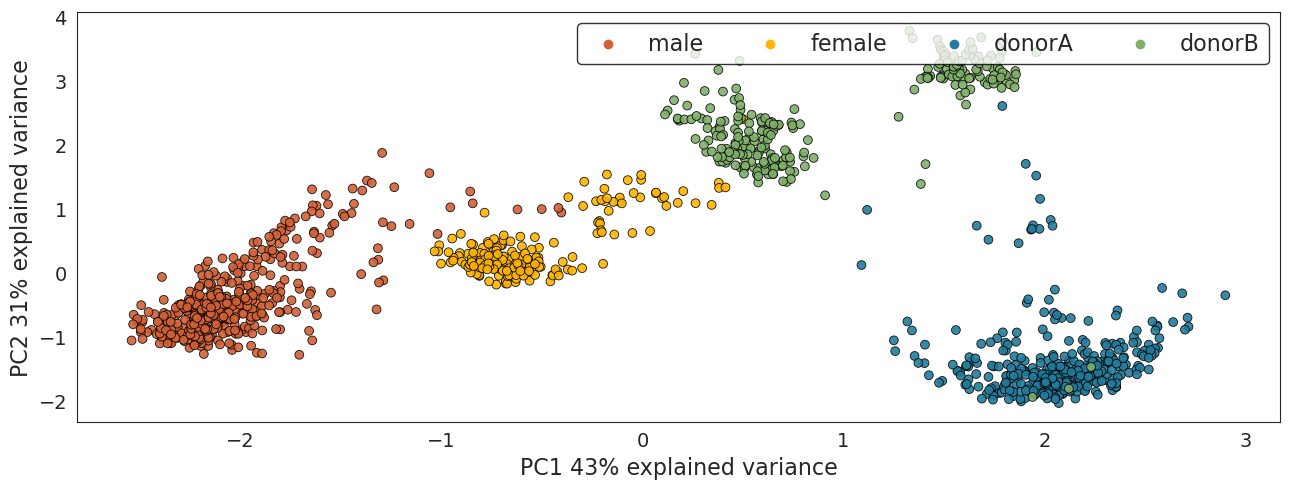

In [11]:
cmap = {'male':'#d36135', 
        'female':'#ffb400' ,
        'donorA':'#227c9d', 
        'donorB':'#7fb069'}

plt.figure(figsize = (13, 5))
ax = sns.scatterplot(
    data = pca_results,
    x = 'PC1', 
    y = 'PC2', 
    hue = 'subject',
    s=40,
    edgecolor='k',
    linewidth=.6,
    palette = cmap,
    alpha = .9)

legend = plt.legend(ncol=4, loc='upper right', fontsize = 16)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)

frame = legend.get_frame()
frame.set_color('white')
frame.set_edgecolor('black')

plt.xlabel('PC1 43% explained variance', size=16)
plt.ylabel('PC2 31% explained variance', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
sns.set_style('white')
plt.tight_layout()

# II. INDIVIDUAL PCA

In [12]:
## change counts int clr
clr_male_df = composition.clr(male_df.drop(['subject'], axis=1)+1)
clr_female_df = composition.clr(female_df.drop(['subject'], axis=1)+1)
clr_donorA_df = composition.clr(donorA_df.drop(['subject'], axis=1)+1)
clr_donorB_df = composition.clr(donorB_df.drop(['subject'], axis=1)+1)


male_dist_matrix = create_normalized_aitchinson_distance_matrix(clr_male_df)
female_dist_matrix = create_normalized_aitchinson_distance_matrix(clr_female_df)
donorA_dist_matrix = create_normalized_aitchinson_distance_matrix(clr_donorA_df)
donorB_dist_matrix = create_normalized_aitchinson_distance_matrix(clr_donorB_df)

In [13]:
def calculate_pca(dist_matrix, n_comp=2):
    
    pca = PCA(n_components=n_comp)
    pca.fit(dist_matrix.values)

    exp_var = pca.explained_variance_ratio_

    pca_results = pd.DataFrame(pca.fit_transform(dist_matrix.values))
    pca_results.columns = ['PC1', 'PC2']
    pca_results['timepoint'] = pca_results.index.astype(float)
    
    return pca_results, exp_var

In [14]:
ncomp=2
male_pca_df, male_var = calculate_pca(male_dist_matrix, ncomp)
female_pca_df, female_var = calculate_pca(female_dist_matrix, ncomp)
donorA_pca_df, donorA_var = calculate_pca(donorA_dist_matrix, ncomp)
donorB_pca_df, donorB_var = calculate_pca(donorB_dist_matrix, ncomp)

### Visualize PCoA

In [15]:
N=256

#male cmap
red = np.ones((N, 4))
red[:, 0] = np.linspace(211/N, 1, N) # R = 255
red[:, 1] = np.linspace(97/N, 1, N) # G = 232
red[:, 2] = np.linspace(53/N, 1, N)  # B = 11
reversed_red = np.flip(red, axis=0)
male_cmp = ListedColormap(reversed_red)
  
#female cmap
yellow = np.ones((N, 4))
yellow[:, 0] = np.linspace(255/N, 1, N) # R = 255
yellow[:, 1] = np.linspace(180/N, 1, N) # G = 232
yellow[:, 2] = np.linspace(0/N, 1, N)  # B = 11

reversed_yellow = np.flip(yellow, axis=0)
female_cmp = ListedColormap(reversed_yellow)

#donorA
blue = np.ones((N, 4))
blue[:, 0] = np.linspace(34/N, 1, N) # R = 255
blue[:, 1] = np.linspace(124/N, 1, N) # G = 232
blue[:, 2] = np.linspace(157/N, 1, N)  # B = 11
reversed_blue = np.flip(blue, axis=0)
donorA_cmp = ListedColormap(reversed_blue)

#donorB
green = np.ones((N, 4))
green[:, 0] = np.linspace(127/N, 1, N) # R = 255
green[:, 1] = np.linspace(176/N, 1, N) # G = 232
green[:, 2] = np.linspace(105/N, 1, N)  # B = 11
reversed_green = np.flip(green, axis=0)
donorB_cmp = ListedColormap(reversed_green)

In [20]:
# PCoA
def plot_individual_pcoa(pcoa_df, var, cmp):
    
    
    fontsize = 14
    ticks_fontsize = 14
    title_fontsize = 16
    legend_fontsize = 14

    plt.figure(figsize = (10, 5))
    sns.scatterplot(pcoa_df['PC1'], pcoa_df['PC2'], 
                    hue = pcoa_df['timepoint'], 
                    s=80, 
                    edgecolor = 'k', 
                    lw=1.4, 
                    alpha = 1, 
                    palette = cmp
                   )

    plt.xlabel(f"PC1: {np.round(var[0] * 100, 2)}%", fontsize=fontsize) 
    plt.ylabel(f"PC2: {np.round(var[1] * 100, 2)}%", fontsize=fontsize) 
    legend = plt.legend(fontsize = legend_fontsize, title='time point', ncol = 1, loc='best', edgecolor = 'black')
    frame = legend.get_frame()
    plt.setp(legend.get_title(),fontsize='x-large')
    plt.xticks(fontsize=14)

    plt.tight_layout()
    plt.savefig('1.png', dpi=300)
    plt.show()

/home/MCB/zkarwowska/anaconda3/envs/qiime_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


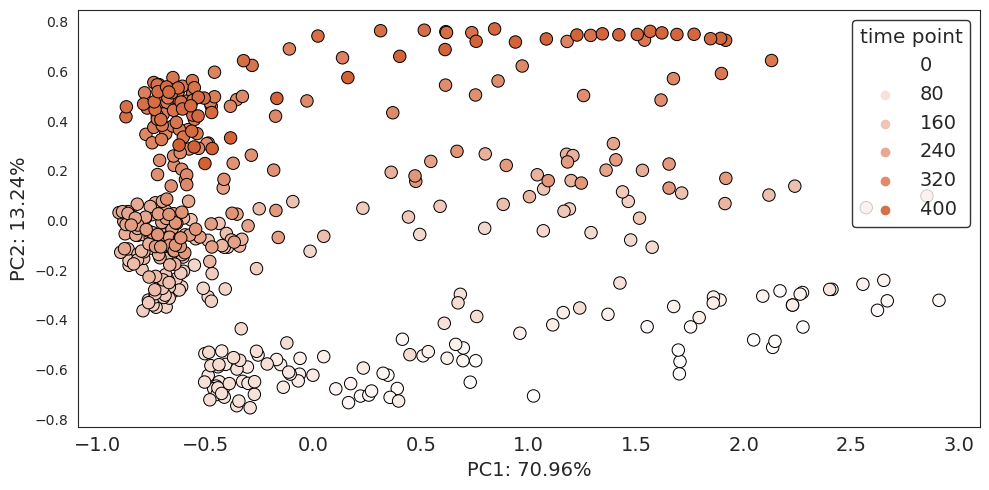

In [21]:
plot_individual_pcoa(male_pca_df, male_var, male_cmp)

/home/MCB/zkarwowska/anaconda3/envs/qiime_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


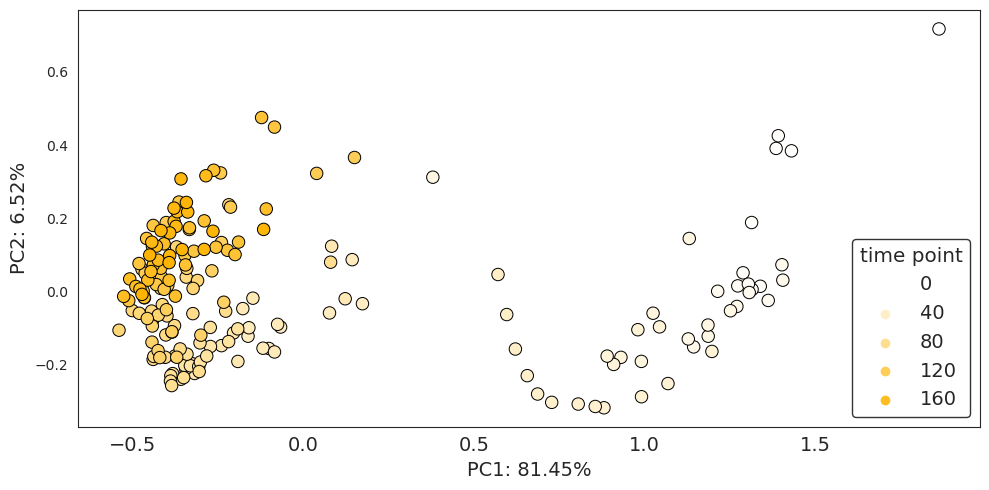

In [49]:
plot_individual_pcoa(female_pca_df, female_var, female_cmp)

/home/MCB/zkarwowska/anaconda3/envs/qiime_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


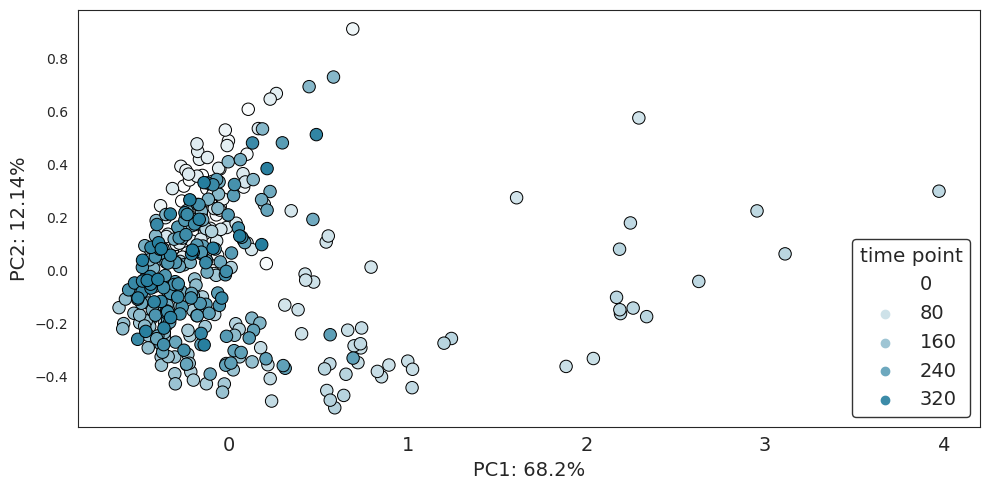

In [50]:
plot_individual_pcoa(donorA_pca_df, donorA_var, donorA_cmp)

/home/MCB/zkarwowska/anaconda3/envs/qiime_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


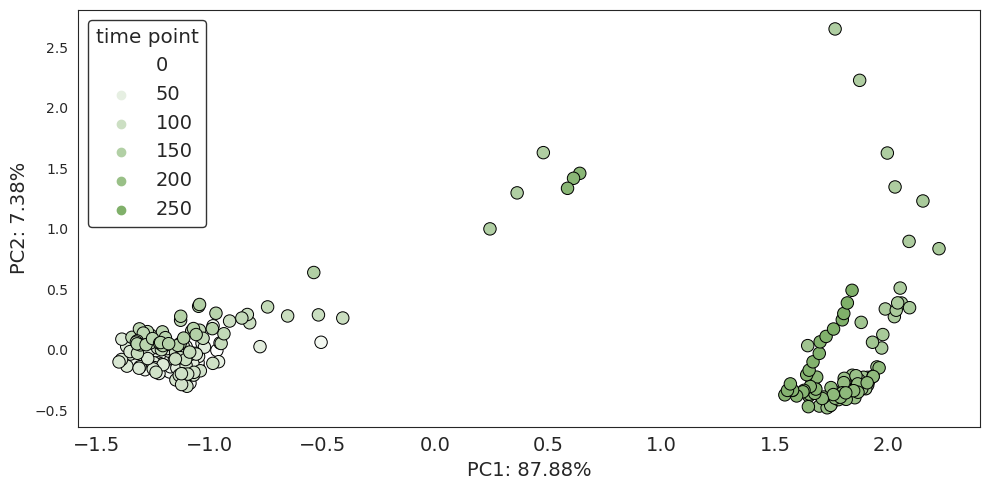

In [52]:
plot_individual_pcoa(donorB_pca_df, donorB_var, donorB_cmp)